<a href="https://colab.research.google.com/github/skyprince999/100Days-of-ML-Code-AY2021/blob/main/DAY%201%23%20DeepLearning_FastAI_Chapter_9_Deep_dive_in_Tabular_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploaded data from the : Blue book for Bulldozers (Kaggle competition)

Source: 
https://www.kaggle.com/c/bluebook-for-bulldozers/data


In [2]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.2MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 37.3MB/s 
     |████████████████████████████████| 194kB 51.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 12.8MB 280kB/s 
     |████████████████████████████████| 776.8MB 18kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
#from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
!unzip "bluebook-for-bulldozers.zip" -d bluebook/

Archive:  bluebook-for-bulldozers.zip
  inflating: bluebook/Data Dictionary.xlsx  
  inflating: bluebook/Machine_Appendix.csv  
  inflating: bluebook/Test.csv       
  inflating: bluebook/Train.7z       
  inflating: bluebook/Train.zip      
  inflating: bluebook/TrainAndValid.7z  
  inflating: bluebook/TrainAndValid.csv  
  inflating: bluebook/TrainAndValid.zip  
  inflating: bluebook/Valid.7z       
  inflating: bluebook/Valid.csv      
  inflating: bluebook/Valid.zip      
  inflating: bluebook/ValidSolution.csv  
  inflating: bluebook/median_benchmark.csv  
  inflating: bluebook/random_forest_benchmark_test.csv  


In [5]:
path = Path('bluebook')
path.ls(file_type='text')

(#7) [Path('bluebook/random_forest_benchmark_test.csv'),Path('bluebook/TrainAndValid.csv'),Path('bluebook/median_benchmark.csv'),Path('bluebook/Machine_Appendix.csv'),Path('bluebook/ValidSolution.csv'),Path('bluebook/Test.csv'),Path('bluebook/Valid.csv')]

In [6]:
# REading the train data csv

df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

Strings have specific meaning (there is order) 

We can tell Pandas about a suitable ordering of these levels like so

In [7]:
df['ProductSize'].unique()
sizes = 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [8]:
# Comverting the dependent OR target variable to log value.
# This de-emphais outliers and allows to build a bell-shaped function 

dep_var = "SalePrice"

df[dep_var] = np.log(df[dep_var])

In [9]:
# Extracting the date components 

df = add_datepart(df, "saledate")

df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, "saledate")

In [10]:
# Check out the new columns

' '.join(col for col in df.columns if col.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [11]:
procs = [Categorify, FillMissing]

In [12]:

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [13]:
# Identifying categorical vs continous variables

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [14]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [15]:
len(to.train),len(to.valid)

(404710, 7988)

In [16]:
#hide_output
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [17]:
#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [18]:
#hide_output
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [19]:
#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [20]:
to.classes['ProductSize']

['#na#', 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']

In [21]:
to.classes['state']

['#na#', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont', 'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin', 'Wyoming']

In [22]:
save_pickle(path/'to.pkl',to)

In [23]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [24]:
# Since all Na values are now replaced. A flag also identifies rows which have a NA value
# Now we train a DT

m = DecisionTreeRegressor(max_leaf_nodes=4) # Only create 4 leaf nodes
m.fit(xs, y);

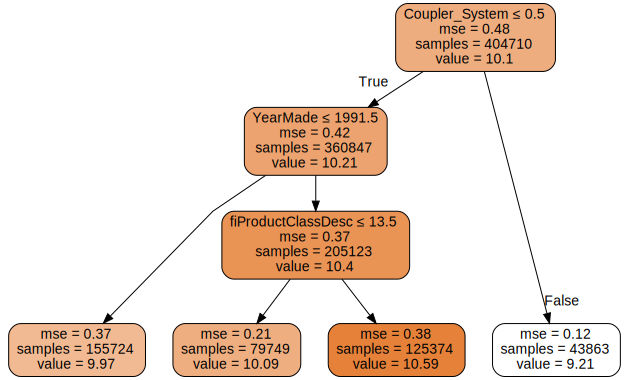

In [25]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [26]:
df[dep_var].mean()

10.105977494816463

Using Terence Parr's :: powerful *dtreeviz* library

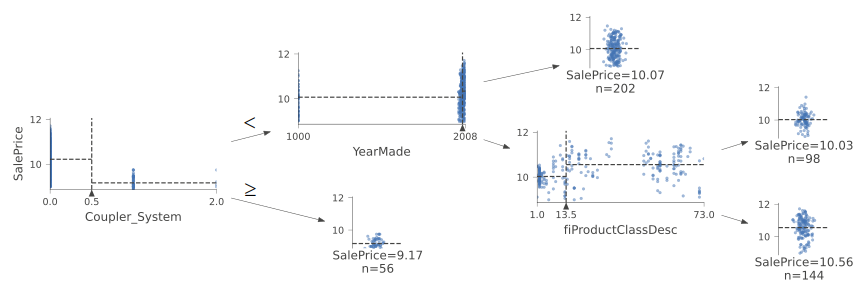

In [27]:
samp_idx = np.random.permutation(len(y))[:500]

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, 
         fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR')

In [28]:
# Replacing NA values in YearMade with 1950,
# This makes the split seen in the above viz more clear

xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

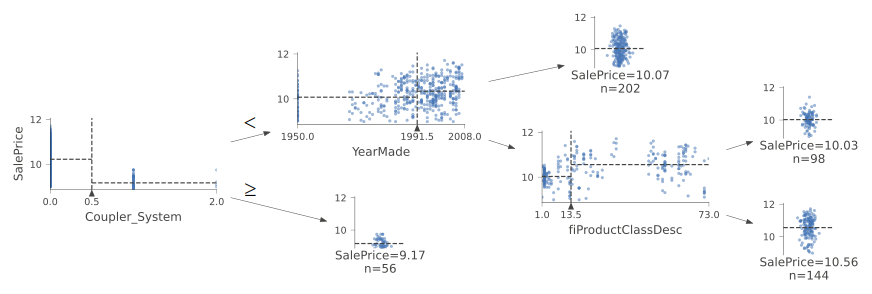

In [29]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [30]:
# DT without any limit on number of leaf nodes
m = DecisionTreeRegressor()
m.fit(xs, y);

In [31]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

m_rmse(m, xs, y)

1e-06

In [32]:
m_rmse(m, valid_xs, valid_y)  ## << Indicated massively overfit model

0.337177

We have overfit the data, this is because there was no limit on the number of leaf nodes. So as we see in the next code block, the DT has created as many leaf nodes as there are data points

In [33]:
m.get_n_leaves(), len(xs)

(324267, 404710)


we will update the parameters, so that there are atlast 25 samples in each leaf-node

In [34]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.245956, 0.314766)

In [35]:
m.get_n_leaves()

12374

In [36]:
#hide
!pip install -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn

Looking in links: https://sklearn-nightly.scdn8.secure.raxcdn.com


In [37]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [38]:
m = rf(xs, y);

In [39]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.1711, 0.23386)

In [40]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

r_mse(preds.mean(0), valid_y)

0.23386

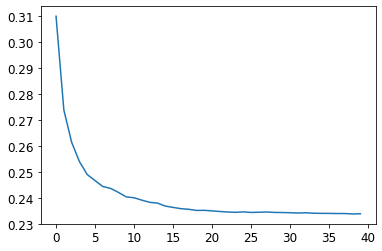

In [41]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [42]:
r_mse(m.oob_prediction_, y) # This is less than our validation error

0.210905

In [43]:
preds.shape

(40, 7988)

In [44]:
preds_std = preds.std(0)

In [45]:
preds_std[:5]

array([0.25218834, 0.10983538, 0.09939201, 0.26840212, 0.12086147])

In [46]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.166835
30,Coupler_System,0.116163
7,fiProductClassDesc,0.084302
6,ProductSize,0.080347
54,ModelID,0.054859
3,fiSecondaryDesc,0.053832
65,saleElapsed,0.050037
31,Grouser_Tracks,0.043968
12,Enclosure,0.040323
1,fiModelDesc,0.038767


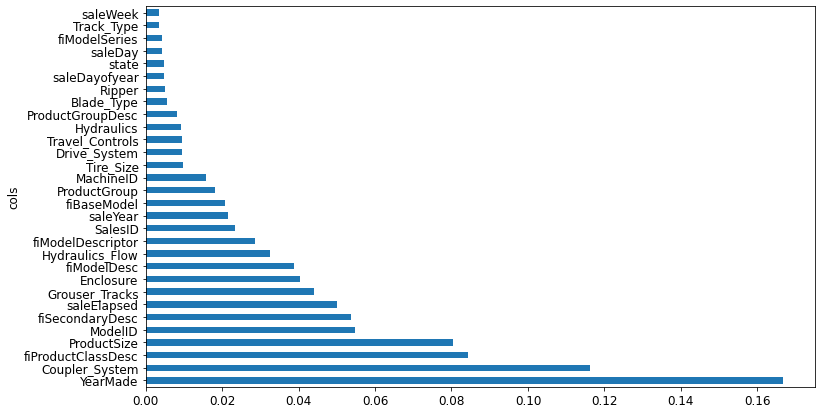

In [47]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [48]:
# keeping variables which are important
# so removing low-important vars

to_keep = fi[fi.imp > 0.005].cols

print(len(to_keep))

print(len(to_keep)/len(fi.cols))

24
0.36363636363636365


In [49]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.180207, 0.232174)

In [50]:
len(xs.columns), len(xs_imp.columns)

(66, 24)

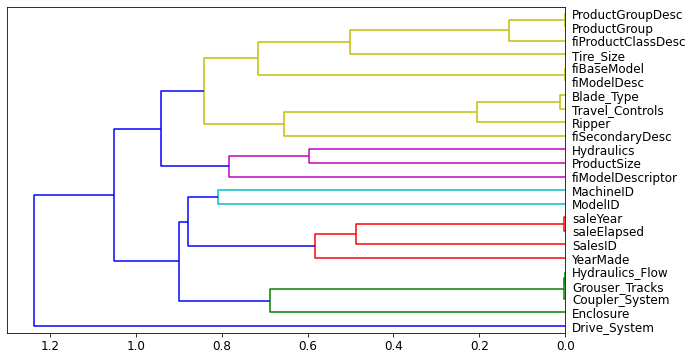

In [51]:
cluster_columns(xs_imp)

In [52]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [53]:
get_oob(xs_imp)

0.8765244952178736

In [54]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8759638211691998,
 'Grouser_Tracks': 0.8764246286134328,
 'Hydraulics_Flow': 0.8753811629700984,
 'ProductGroup': 0.8763922882169946,
 'ProductGroupDesc': 0.8760698610294768,
 'fiBaseModel': 0.8746041012173912,
 'fiModelDesc': 0.8749350199173064,
 'saleElapsed': 0.8702969585009405,
 'saleYear': 0.8756394629738579}

In [55]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8749338390264518

In [56]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [57]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.181851, 0.233581)

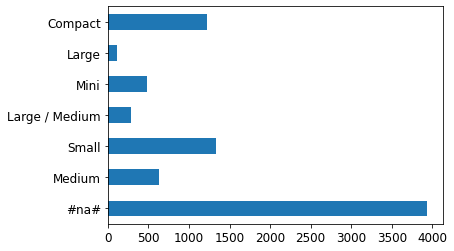

In [59]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

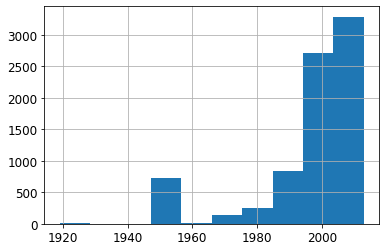

In [60]:
ax = valid_xs_final['YearMade'].hist()

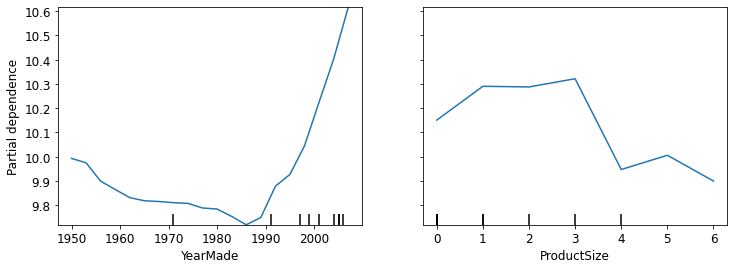

In [61]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

In [62]:
#hide

# !pip install treeinterpreter
# !pip install waterfallcharts
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [63]:
row = valid_xs_final.iloc[:5]

In [64]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [65]:
prediction[0], bias[0], contributions[0].sum()

(array([10.03602492]), 10.104746057831763, -0.0687211363163581)

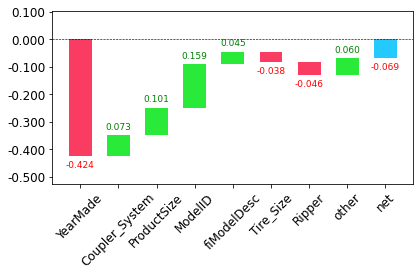

In [66]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

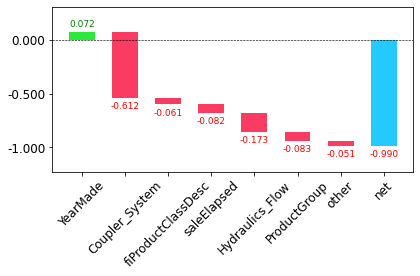

In [68]:
waterfall(valid_xs_final.columns, contributions[3], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [69]:
#hide
np.random.seed(42)

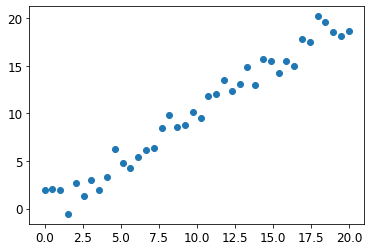

In [70]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [71]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [72]:
x_lin[:,None].shape

torch.Size([40, 1])

In [73]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

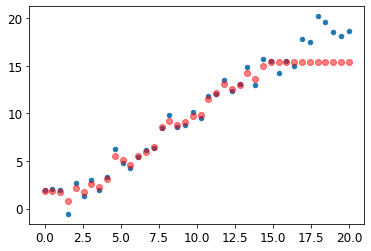

In [74]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [75]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.891253
11,SalesID,0.088248
13,MachineID,0.016535
0,YearMade,0.001004
14,Tire_Size,0.000503
4,ModelID,0.000454


In [76]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.233498
SalesID 0.230427
saleElapsed 0.236922
MachineID 0.232213


In [77]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229547

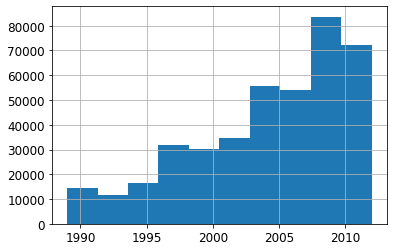

In [78]:
xs['saleYear'].hist();

In [79]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.175296, 0.228967)

In [81]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [82]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [83]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [84]:
cont_nn


['saleElapsed']

In [85]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
fiProductClassDesc      74
ProductSize              6
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
Hydraulics_Flow          3
fiModelDescriptor      140
ProductGroup             6
Tire_Size               17
Drive_System             4
Travel_Controls          7
Hydraulics              12
Blade_Type              10
Ripper                   4
dtype: int64

In [86]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176879, 0.230138)

In [87]:
cat_nn.remove('fiModelDescriptor')

In [88]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [89]:
dls = to_nn.dataloaders(1024)

In [90]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [91]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0002754228771664202)

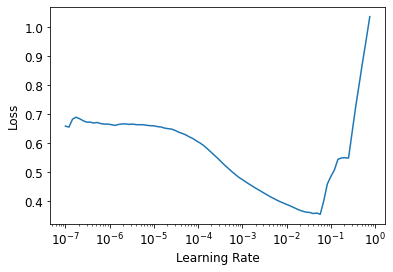

In [92]:
learn.lr_find()

In [93]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069687,0.062366,01:08
1,0.055734,0.056702,01:06
2,0.048317,0.053643,01:09
3,0.043072,0.051197,01:07
4,0.040065,0.051102,01:05


In [94]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.226058

In [95]:
learn.save('nn')

Path('models/nn.pth')

In [96]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [97]:
r_mse(ens_preds,valid_y)

0.222061